# Trabalho 02: Regressão Logística Bayesiana
Andreza Fernandes de Oliveira


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path = "/content/drive/MyDrive/Acadêmico/UFC/Mestrado/Disciplinas/2020.2/Tópicos Especiais em Lógica II/TRABALHOS/Trabalho 02/"

## 01. Implementação do modelo de Regressão Logística Bayesiana 

In [105]:
data = pd.read_csv(path+"logistic_regression_data.csv", header=None)
data.head(10)

,0,1,2
0,1.581472,-1.449020,0.0
1,2.032725,-1.108874,0.0
2,0.874624,-0.746390,0.0
3,-1.695795,-0.546513,1.0
4,1.592453,-0.772068,0.0
5,-0.678388,0.161669,1.0
6,2.282039,0.501108,0.0
7,0.954317,-2.187928,0.0
8,-1.145477,0.541343,1.0
9,1.896627,-1.023025,0.0


Text(0.5, 1.0, 'Distribuição dos dados')

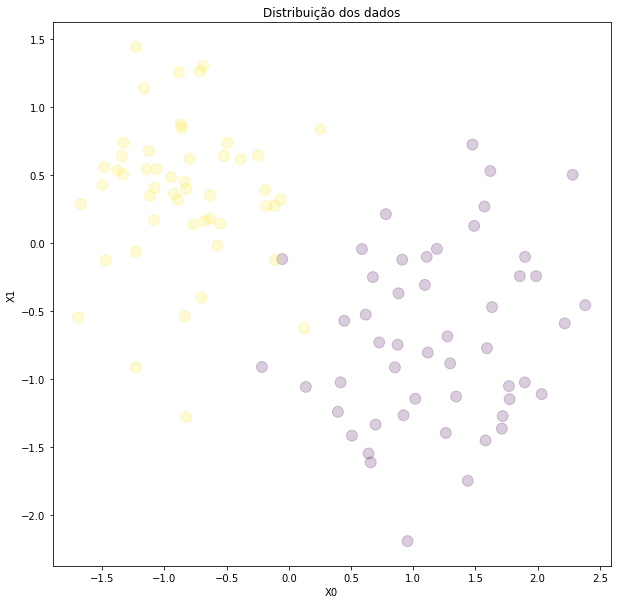

In [106]:
plt.figure(figsize=(10,10))
plt.scatter(data[0], data[1], alpha=0.2, s=120, c=data[2], cmap='viridis')
plt.xlabel('X0')
plt.ylabel('X1');
plt.title(f'Distribuição dos dados')

In [142]:
x = data[[0, 1]].values
x_train = np.concatenate([np.ones((len(x),1)), x], axis=1)
y = data[2].values

# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

D = x_train.shape[1]
N = x_train.shape[0]
u0 = np.zeros(D)
S0 = np.identity(D)
S0_inv = np.linalg.inv(S0) 
w = np.zeros(D)

In [143]:
def expand(x):
    return np.concatenate([np.ones(len(x), 1), x], axis=1)

def sigmoide(x, w): # retorna [N, 1]
    return 1/(1+np.exp(-x @ w))

def R_t_1(w, x): # retorna [N, N]
    o_ = sigmoide(x, w)
    return np.diag((o_ * (1-o_)).ravel())

def R_hat(w, x): # retorna [N, N]
    o_ = sigmoide(x, w.T)
    return np.diag((o_ * (1-o_)).ravel())

def A(x, w, S0_inv): # retorna [D, D]
    # x_train = [N, D]
    # x_train.T = [D, N]
    # R_t_1 = [N, N]
    # M1 = x_train.T.dot(R_t_1(w, x_train)) = [D, N] 
    # M1.dot(x_train) = [D, D]
    return x.T.dot(R_t_1(w, x)).dot(x) + S0_inv

def H(x, R, S0_inv): # retorna [D, D]
    return x.T.dot(R).dot(x) + S0_inv

def fit(x_train, y_train, u0, S0, S0_inv, epochs=200): # retorna [D, 1]
    w = np.zeros(D)

    for epoch in range(epochs):
        a = A(x_train, w, S0_inv) # [D, D]
        y_pred = sigmoide(x_train, w) # [N, 1]
        w = w + np.linalg.inv(a).dot(x_train.T.dot(y - y_pred) - S0_inv.dot(w - u0)) # [D, 1]
    return w

def posteriori(x_train, y_train, u0, S0, S0_inv): # retorna [D, 1], [D, D], [D, D]
    w = fit(x_train, y_train, u0, S0, S0_inv)

    R_hat_ = R_hat(w, x_train) # [N, N]
    H_ = H(x_train, R_hat_, S0_inv) # [D, D]
    H_inv = np.linalg.inv(H_) # [D, D]

    return w, H_, H_inv

def predict_probit(x_test, w, H_): # retorna [D, D]
    u_a = x_test.dot(w)
    o_a = x_test.dot(H_).dot(x_test.T)
    miolo = np.sqrt(1 + np.pi*o_a/8)
    y_pred = sigmoide(miolo, u_a)
    return y_pred, u_a, o_a

In [145]:
w, H_, H_inv = posteriori(x_train, y_train, u0, S0, S0_inv)

y_pred, u_a, o_a = predict_probit(x_train, w, H_inv)

# 2. Visualizações

In [ ]:
from scipy import stats

def plot_data(x, t, label=None):
    plt.scatter(x, t, marker='o', c="k", s=50, label=label)

def plot_valor_esperado(x, y, label=None):
    plt.plot(x, y, 'x', color='r', label=label)

def plot_predictive(x, y, En, std_times=1):
    y = y.ravel()
    En = np.sqrt(En.ravel()) * std_times

    plt.plot(x, y, label="Predição")
    plt.fill_between(x.ravel(), y + En, y - En, alpha = .5, label="Incerteza")

def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r--', alpha=0.5, label='Modelos')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r--', alpha=0.5)

def plot_posterior(mean, cov, resolution = 100):
    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))

In [ ]:
def apply_bayesian_regression(data, ruido, E0, design_function=identity, samples_sizes=[1, 3, 5, 10], figsize=(20, 20), poly=False):
    n_experiments = len(samples_sizes)

    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=.4)
    n_plots = 3

    # Repartindo os dados
    X = np.array([data[0].values]).T
    X_phi = expand(design_function(X))
    y = np.array([data[1].values]).T

    for i, n in enumerate(samples_sizes):
        X_n = X[:n]
        X_phi_n = X_phi[:n]
        y_n = y[:n]
        
        # INFERENCIA: Mean and covariance matrix of posterior
        un, En = posteriori_inferencia(X_phi_n, y_n, E0, ruido)
        
        # PREDICAO: Mean and variances of posterior predictive 
        y, y_var = posteriori_predicao(X_phi, un, En, ruido) #TODO: ver pq ta passando o X TODO
        
        # Draw 5 random weight samples from posterior and compute y values
        w_samples = np.random.multivariate_normal(un.ravel(), En, 5).T
        y_samples = X_phi.dot(w_samples)

        # PLOTS
        if poly == False:
            # plot 01: densidade
            plt.subplot(n_experiments, n_plots, i * n_plots + 1)
            plot_posterior(un, En)
            plt.title(f'Densidade da Posteriori com  (N = {n}) amostras')

        # plot 02: modelos
        plt.subplot(n_experiments, n_plots, i * n_plots + 2)
        plot_valor_esperado(X, y, label="Valor esperado") # valores esperados para a predição
        plot_data(X_n, y_n, label="Dados de treino") # valores utilizados para o treinamento do modelo
        plot_posterior_samples(X, y_samples)
        plt.title(f'Modelos gerados com  (N = {n}) amostras')
        plt.legend()

        plt.subplot(n_experiments, n_plots, i * n_plots + 3)
        plot_valor_esperado(X, y)
        plot_data(X_n, y_n, label="Dados de treino")
        plot_predictive(X, y, np.sqrt(y_var))
        plt.title(f"Variância média: {np.round(np.mean(y_var), 3)} | (N = {n}) amostras ")
        plt.legend()

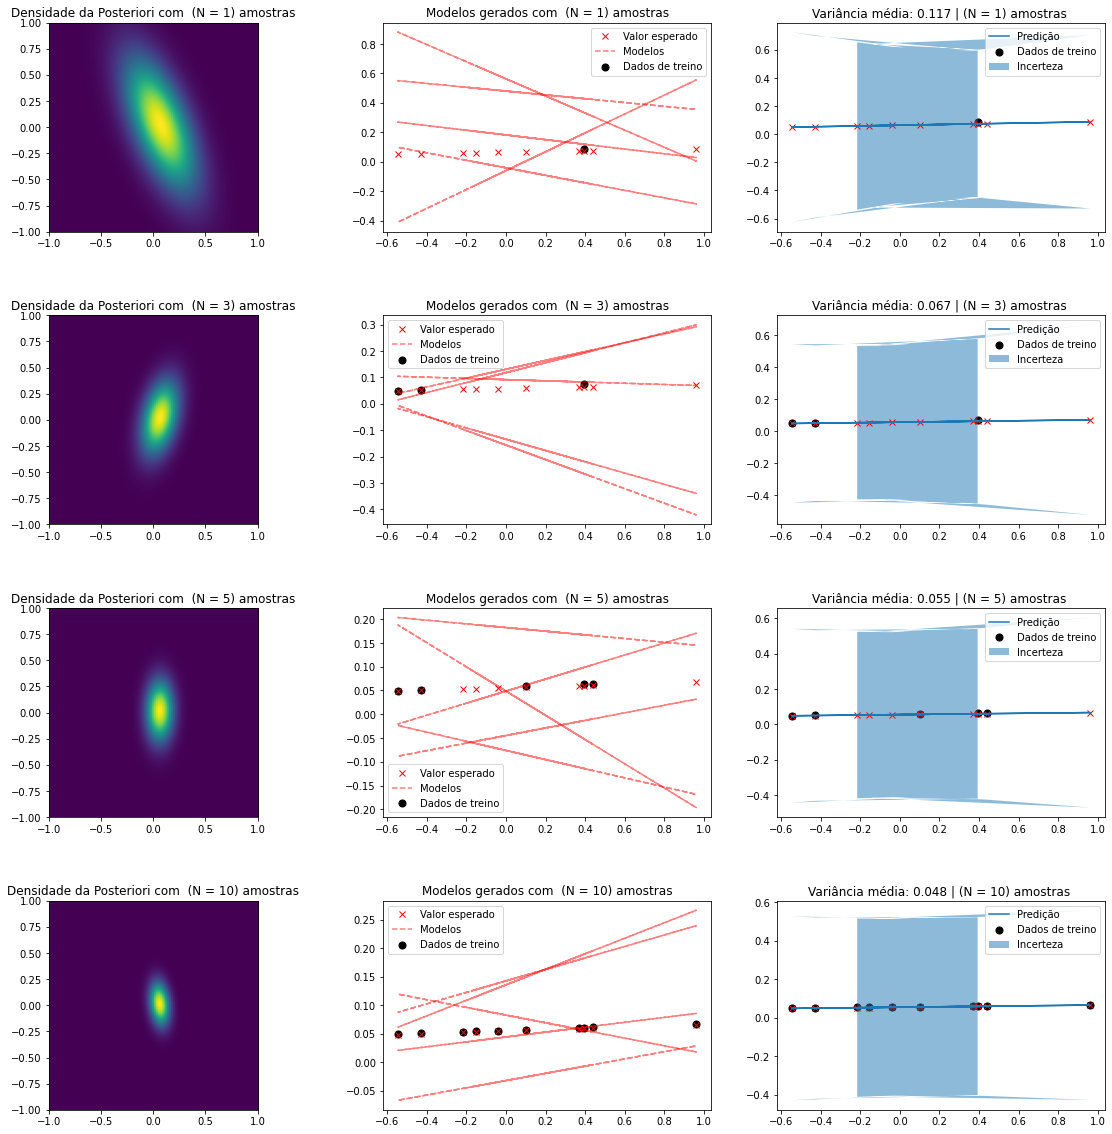

In [ ]:
ruido = 25.0
E0 = 5.0

apply_bayesian_regression(data_1, ruido, E0)

## 02. Implementação do modelo de Regressão Polinomial Bayesiana

Utilize um modelo polinomial de grau 5.

Apresente um gráfico contendo os dados e uma representação da distribuição preditiva encontrada (escolha um metodo de aproximação).

Esta representação consistirá na curva da média e nas curvas da média mais 2 desvios padrões e média menos 2 desvios padrões.

In [ ]:
data_2 = pd.read_csv(path+"polynomial_regression_data.csv", header=None)
data_2.head(10)

,0,1
0,0.696469,-0.851271
1,0.286139,0.910864
2,0.226851,0.939731
3,0.551315,-0.323798
4,0.719469,-0.872451
5,0.423106,0.417776
6,0.980764,-0.153078
7,0.684830,-0.949134
8,0.480932,0.281049
9,0.392118,0.787241


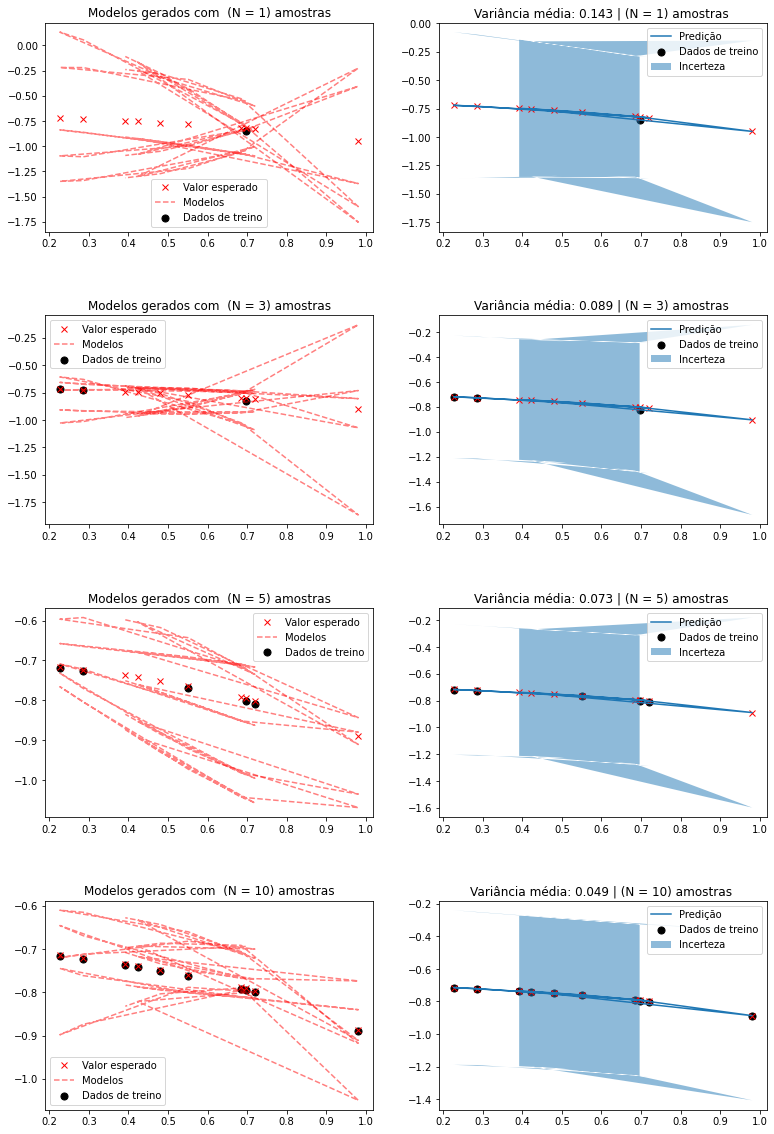

In [ ]:
apply_bayesian_regression(data_2, ruido, E0, polinomial, poly=True)